### Initialize Notebook

In [1]:
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install openai
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import dotenv
import json
import requests

dotenv.load_dotenv()

resource_group = os.getenv("RESOURCE_GROUP")
subscription_id = os.getenv("SUBSCRIPTION_ID")
apim_eus_resource_url = os.getenv("APIM_EUS_RESOURCE_URL")
apim_wus_resource_url = os.getenv("APIM_WUS_RESOURCE_URL")
apim_subscription_key = os.getenv("APIM_SUBSCRIPTION_KEY")
openai_deployment_name = os.getenv("OPENAI_DEPLOYMENT_NAME")
openai_model_name = os.getenv("OPENAI_MODEL_NAME")
openai_api_version = os.getenv("OPENAI_API_VERSION")
app_insights_app_id = os.getenv("APP_INSIGHTS_APP_ID")

### Token Limit Policy

1. Test API Token

In [3]:
url = apim_eus_resource_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(10):
    messages={"messages":[
        {"role": "system", "content": "You are an intelligent assistant."},
        {"role": "user", "content": "Can you tell me a long winded fact?"}
    ]}
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Of course! Did you know that the Great Wall of China, one of the most iconic and ambitious construction projects in human history, stretches over approximately 13,171 miles (21,196 kilometers)? This colossal structure wasn't built all at once; rather, it was constructed in various segments over several dynasties. 

The origins of the Great Wall can be traced back to as early as the 7th century BCE, during the Warring States period, when various feudal states built defensive walls to protect their territories from invasions by rival states and nomadic tribes. However, the most famous sections of the wall were built during the Ming Dynasty (1368–1644), when the rulers embarked on an extensive construction project to fortify the northern borders of China against invasions by the Mongols and other nomadic groups from the Eurasian Steppe. 

Constructed using a combination of brick, tamped earth, wood, and stone, the Great Wall winds its way through diverse 

2. Analyze results

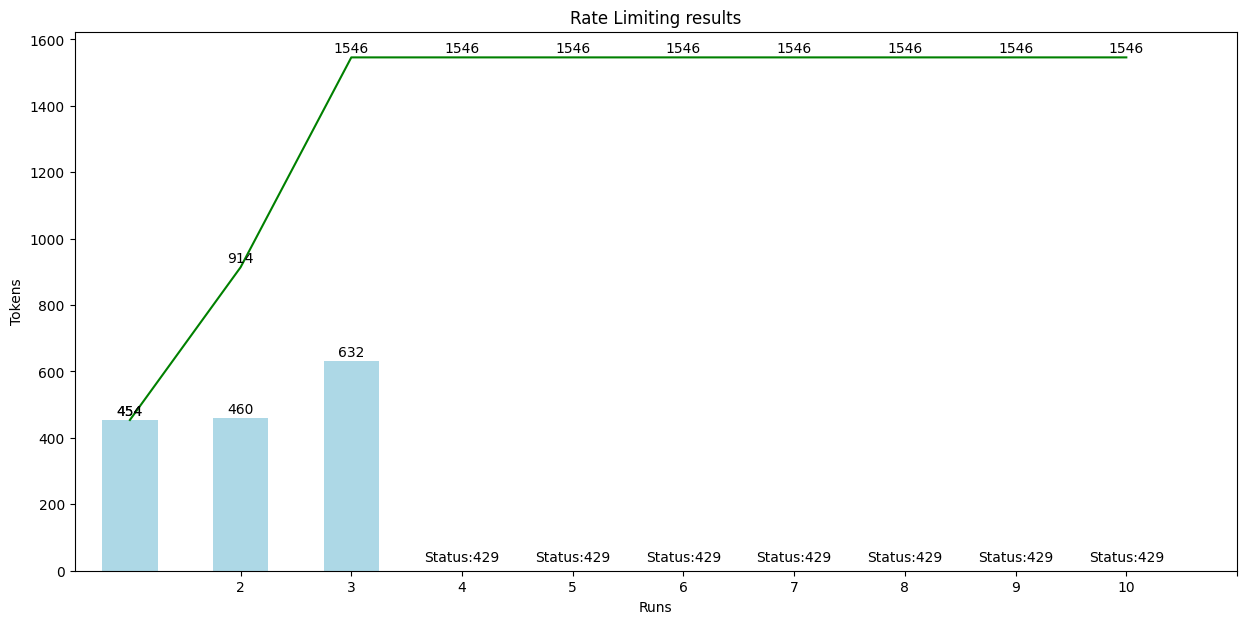

In [4]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else int(val), ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, int(val), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

### 🔍 Token Emit Policy - App Insights

Example

```
<azure-openai-emit-token-metric namespace="openaiTeamA">
            <dimension name="Subscription ID" value="@(context.Subscription.Id)" /> 
            <dimension name="Client IP" value="@(context.Request.IpAddress)" />
            <!--  <dimension name="API ID" value="@(context.Variables.GetValueOrDefault('extractedApiId', 'N/A'))" /> -->
            <dimension name="User ID" value="@(context.Request.Headers.GetValueOrDefault("x-user-id", "N/A"))" />
        </azure-openai-emit-token-metric>
```

<a id='plot'></a> 
### 🔍 Load Balancing & Circuit breaking

LB Types
1. Round Robin
2. Weighted
3. Priority

In [5]:
! az deployment group create --resource-group {resource_group} --template-file "infrastructure/lb-ai-gateway.bicep"

/Users/jimmyshah/workspace/azure-ai-notebooks/infrastructure/lb-ai-gateway.bicep(71,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is an inaccuracy in the documentation, please report it to the Bicep Team. [https://aka.ms/bicep-type-issues]

{- Finished .. - Starting ..
  "id": "/subscriptions/c72983e8-50a6-45fe-a344-c897e45e10a7/resourceGroups/rg-cc-interac-demo/providers/Microsoft.Resources/deployments/lb-ai-gateway",
  "location": null,
  "name": "lb-ai-gateway",
  "properties": {
    "correlationId": "d57dc7dc-9cda-4ec1-b4f0-b4f388b96fda",
    "debugSetting": null,
    "dependencies": [
      {
        "dependsOn": [
          {
            "id": "/subscriptions/c72983e8-50a6-45fe-a344-c897e45e10a7/resourceGroups/rg-cc-interac-demo/providers/Microsoft.ApiManagement/service/apim-js-genai-gateway-demo",
            "resourceGroup": "rg-cc-interac-demo",
            "resourceName": "apim-js-genai-gateway

## Test LB

In [8]:
url = apim_eus_resource_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
messages={"messages":[
    {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
    {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
print("status code: ", response.status_code)
print("headers ", response.headers)
print("x-ms-region: ", response.headers.get("x-ms-region")) # this header is useful to determine the region of the backend that served the request
print("x-ms-openai: ", response.headers.get("x-ms-openai")) 

if (response.status_code == 200):
    data = json.loads(response.text)
    print("response: ", data.get("choices")[0].get("message").get("content"))
else:
    print(response.text)

KeyboardInterrupt: 

-- Test Load Balancing

<a id='plot'></a>
### 🔍 Analyze Semantic Caching Testing

In [6]:
sc_endpoint = os.environ["SC_ENDPOINT"]
sc_api_key = os.environ["SC_API_KEY"]
sc_api_version = os.environ["SC_API_VERSION"]
sc_openai_deployment_name = os.environ["SC_OPENAI_DEPLOYMENT_NAME"]
sc_openai_model_name = os.environ["SC_OPENAI_MODEL_NAME"]
sc_subscription = os.environ["SC_SUBSCRIPTION"]

In [7]:
!az account set --subscription {sc_subscription}

In [8]:
from openai import AzureOpenAI
import time, random

runs = 10
questions = ["Provide a short fact", 
             "Tell me a short story", 
             "What is the meaning of life",]
api_runs = [] 
for i in range(runs):
    random_question = random.choice(questions)
    messages=[
        {"role": "system", "content": "You are a insightful assistant."},
        {"role": "user", "content": random_question}
    ]
    client = AzureOpenAI(azure_endpoint=sc_endpoint, api_key=sc_api_key, api_version=sc_api_version)
    start_time = time.time()
    response = client.chat.completions.create(model=sc_openai_model_name, messages=messages)
    response_time = time.time() - start_time
    print("▶️ Run: ", i+1, f"duration: {response_time:.2f} seconds")
    print("💬 ", random_question, " ----> ", response.choices[0].message.content)
    api_runs.append(response_time)

▶️ Run:  1 duration: 12.64 seconds
💬  Provide a short fact  ---->  Did you know that honey never spoils? Archaeologists have discovered pots of honey in ancient Egyptian tombs that are over 3,000 years old and still perfectly edible.
▶️ Run:  2 duration: 1.58 seconds
💬  What is the meaning of life  ---->  The meaning of life is subjective and can vary for each individual. Some common interpretations include finding personal happiness and fulfillment, forming meaningful connections with others, pursuing personal passions and goals, making a positive impact on the world, or seeking spirituality and personal growth. It ultimately depends on one's beliefs, values, and aspirations.
▶️ Run:  3 duration: 0.43 seconds
💬  Provide a short fact  ---->  Did you know that honey never spoils? Archaeologists have discovered pots of honey in ancient Egyptian tombs that are over 3,000 years old and still perfectly edible.
▶️ Run:  4 duration: 0.26 seconds
💬  What is the meaning of life  ---->  The mean

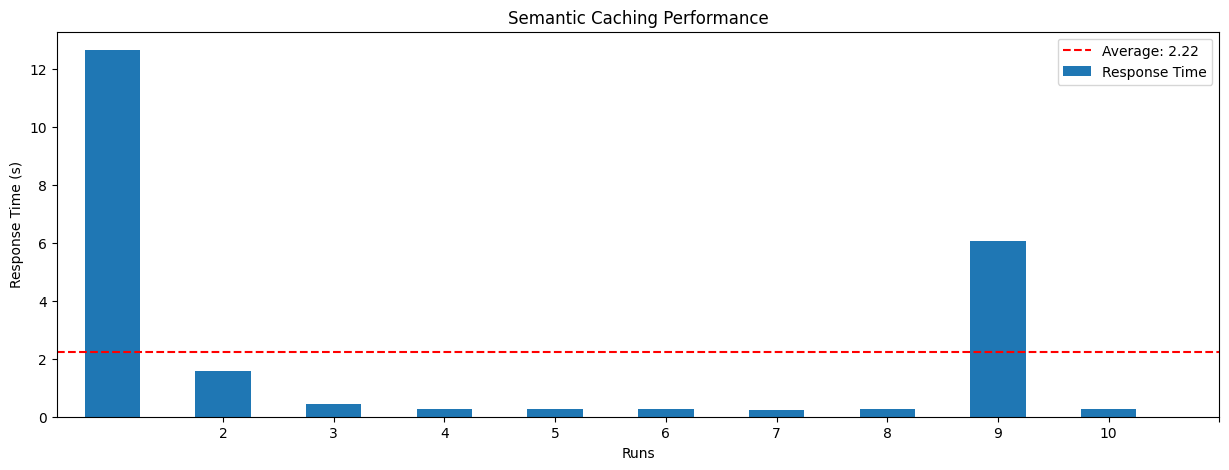

In [9]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(api_runs, columns=['Response Time'])
df['Run'] = range(1, len(df) + 1)
df.plot(kind='bar', x='Run', y='Response Time', legend=False)
plt.title('Semantic Caching Performance')
plt.xlabel('Runs')
plt.ylabel('Response Time (s)')
plt.xticks(df['Run'], rotation=0)  # Set x-axis ticks to be the run numbers

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()